# Trading Bot 

This is a simplified Version of a trading bot, which follows the idea of mean reversion. It is a trading strategy that is based on the assumption that the price will tend to move back towards it average price. 

--> Conclusion: You buy an asset when its price is lower than its mean and sell when its higher. Traders with this strategy search for strong price movements. 
I used indicators like RSI and Bollinger Bands.

**Some Drawbacks:**
* if the stock drops for a major reason (structural change, etc.) the chances that the stock will go back to its mean is smaller
* Strong price movements can go on for a longer time


**This is bot is very simplified and should definitely not be used for actual trading. It can definitely be improved by adding backtesting**

The main goal was to implement the rsi and bollinger bands from scratch and create a very simple bot.

In [ ]:
# import libaries
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
START = "2022-06-01"
END = "2023-06-01"
TICKER = "^GSPC"

In [ ]:
df = yf.download(TICKER, start = START, end = END)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-01,4149.779785,4166.540039,4073.850098,4101.229980,4101.229980,4531800000
2022-06-02,4095.409912,4177.509766,4074.370117,4176.819824,4176.819824,4405790000
2022-06-03,4137.569824,4142.669922,4098.669922,4108.540039,4108.540039,3711110000
2022-06-06,4134.720215,4168.779785,4109.180176,4121.430176,4121.430176,4332700000
2022-06-07,4096.470215,4164.859863,4080.189941,4160.680176,4160.680176,4248210000


In [ ]:
df = df.dropna()

## Calculate the bollinger bands

Instead of using libaries I want to initialize the bollinger bands on my own using information from the corresponding wikipedia page.


In [ ]:
# calculate the bollinger bands
def bollinger_bands(price, n, k):
  """
  Calculates and plots the Bollinger Bands for a given time series.

  Bollinger Bands are a popular technical analysis tool that consists of a middle band, an upper band, and a lower band. 
  The middle band is the N-period moving average of the closing prices. The upper band is K times the standard deviation
  above the middle band, and the lower band is K times the standard deviation below the middle band.

  Parameters:
        price (list/pandas series): List of prices.
        n (int): N-period moving average and standard deviation.
        k (int): K-times the standard deviation.

  Returns:
        Pandas Dataframe containing:
            lower_band (pd. Series): List of lower band values.
            middle_band (pd Series): List of middle band values (N-period moving average).
            upper_band (pd Series): List of upper band values.
            bandwidth (pd Series): Width between lower and upper Band divided by middle Band
  """

  middle_band = price.rolling(window=n).mean()

  std = price.rolling(window=n).std()
  lower_band = middle_band - k * std
  upper_band = middle_band + k * std

  bandwith = (upper_band - lower_band) / middle_band

  # plot bollinger bands
  plt.figure(figsize=(10,6))
  plt.plot(middle_band, label="middle band")
  plt.plot(lower_band, label="lower band")
  plt.plot(upper_band, label="upper band")
  plt.plot(price, label="price")
  plt.xticks(rotation=45)
  plt.legend()
  plt.title("Bollinger Bands")
  plt.fill_between(x=price.index,y1=lower_band, y2=upper_band, color="grey", alpha=0.2)
  plt.show();

  # return Dataframe 
  return pd.DataFrame({"lower_band_bb": lower_band,
                       "middle_band_bb": middle_band,
                       "upper_band_bb": upper_band,
                       "bandwith_bb": bandwith})


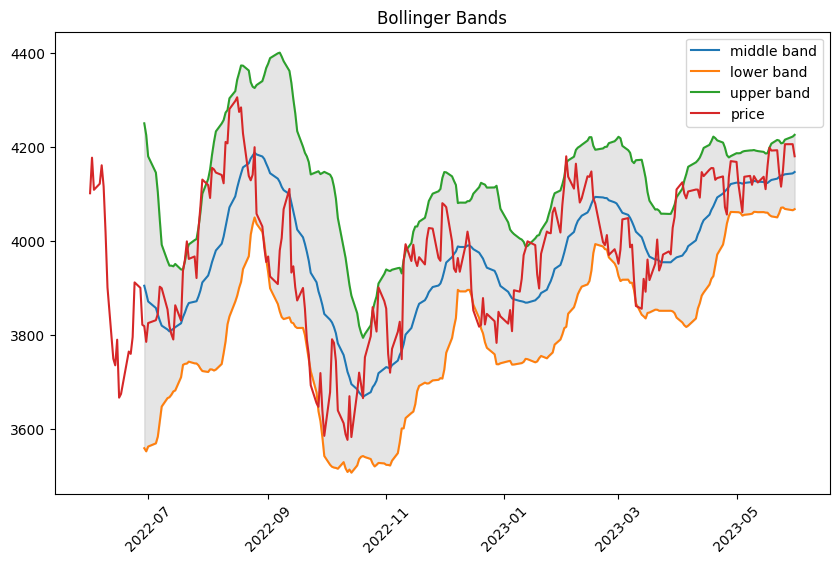

In [ ]:
bb_bands = bollinger_bands(df.Close, 20, 2)

In [ ]:
df = pd.concat([df, bb_bands])
df.head()

,Open,High,Low,Close,Adj Close,Volume,lower_band_bb,middle_band_bb,upper_band_bb,bandwith_bb
Date,,,,,,,,,,
2022-06-01,4149.779785,4166.540039,4073.850098,4101.229980,4101.229980,4.531800e+09,NaN,NaN,NaN,NaN
2022-06-02,4095.409912,4177.509766,4074.370117,4176.819824,4176.819824,4.405790e+09,NaN,NaN,NaN,NaN
2022-06-03,4137.569824,4142.669922,4098.669922,4108.540039,4108.540039,3.711110e+09,NaN,NaN,NaN,NaN
2022-06-06,4134.720215,4168.779785,4109.180176,4121.430176,4121.430176,4.332700e+09,NaN,NaN,NaN,NaN
2022-06-07,4096.470215,4164.859863,4080.189941,4160.680176,4160.680176,4.248210e+09,NaN,NaN,NaN,NaN


In [ ]:
df = df.fillna(0)

## RSI Indicator


In [ ]:
def rsi(price, n, upper_signal=70, lower_signal=30):
  """
  Computes the RSI-indicator (Relative Strength Index).

  The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. 
  It ranges between 0 and 100 and is commonly used to identify overbought and oversold conditions in a market.

  Parameters:
        price (list):  price values.
        n (int): Timeframe. Recommended values: 14 or 21.
        upper_signal (int): Signal level for overbuying. Recommended value: 70.
        lower_signal (int): Signal level for oversold. Recommended value: 30.

  Returns:
        rsi (list): Relative Strength Index values.
  """

  price = pd.Series(price)

  # calculate the changes 
  diff = price.diff().dropna()

  # calculate the mean for the positive and negative changes
  positive_change = diff.copy()
  negative_change = diff.copy()

  positive_change[positive_change < 0] = 0 # set negative changes to 0
  negative_change[negative_change > 0] = 0


  # calculate the rolling mean for the given n-timeframe
  positive_mean = positive_change.rolling(n).mean() 
  negative_mean = negative_change.rolling(n).mean().abs()

  # calculate rsi
  rsi = 100 - (100 / (1 + negative_mean/positive_mean))

  # plot the rsi
  plt.plot(rsi, label="relative strength index")
  plt.axhline(upper_signal, color="r", linestyle="--", label="Overbuying Signal")
  plt.axhline(lower_signal, color="g", linestyle="--", label="Oversold Signal")
  plt.xticks(rotation=45)
  plt.title("Relative Strength index")
  plt.legend()

  return pd.DataFrame({"rsi": rsi})

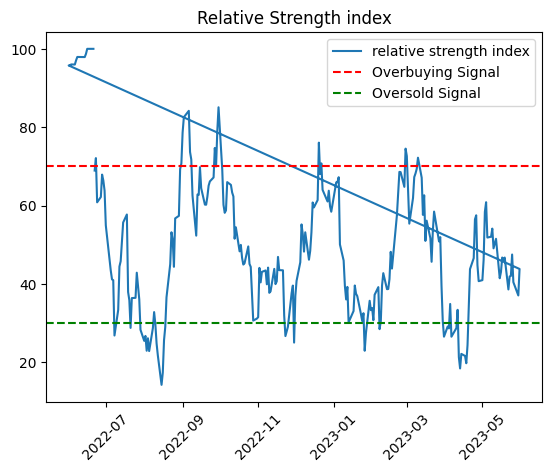

In [ ]:
rsi_calculated = rsi(df.Close, 14, 70, 30)

In [ ]:
df = pd.concat([df, rsi_calculated])

## Trading strategy

Combing both indicators to generate buy and sell signals.
For example, if the RSI crosses below the oversold threshold or the price touches or crosses the lower Bollinger Band, it may generate a buy signal. If the RSI crosses the overbought threshold or the price touches or crosses the upper Bollinger Band, it max generate a sell signal.


In [ ]:
def buy_sell_signal(price, lower_band, upper_band, rsi, upper_signal=70, lower_signal=30):
  """
  Generates buying or selling signal for given price based on the rsi and 
  bollinger bands.
  Buying signal, if the RSI crosses below the oversold threshold or the prices 
  touches or crosses the lower Bollinger band and v.v.

  Parameters:
        price (float): Stock price
        lower_band (float): lower Bollinger band
        upper_band(float): upper Bollinger band
        rsi (float): Relative Strength Index
        upper_signal (int): Signal level for overbuying. Recommended value: 70.
        lower_signal (int): Signal level for oversold. Recommended value: 30.

  Returns:
        0: hold signal
        1: buying signal
        2: selling signal
  """
  # buying signal
  if rsi < lower_signal or price <= lower_band:
    return 1
  # selling signal
  if rsi > upper_signal or price >= upper_band:
    return 2
  # hold signal - no action
  return 0 



In [ ]:
df["signal"] = df.apply(lambda column: buy_sell_signal(column.Close,
                                                    column.lower_band_bb,
                                                    column.upper_band_bb,
                                                    column.rsi), axis=1)

<Axes: ylabel='Frequency'>

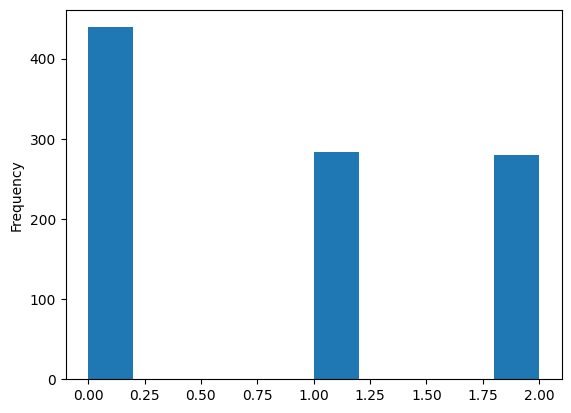

In [ ]:
# view distribution
df["signal"].plot(kind="hist")

## Let's implement it with an API



In [ ]:
!pip install alpaca-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 5.6 MB/s eta 0:00:00


In [ ]:
import alpaca_trade_api as tradeapi

In [ ]:
key = "key"
endpoint = "endpoint"
secret = "secret"
ticker = "AAPL"
qty = 10
start = "2023-01-01"
end = "2023-06-10"

In [ ]:
api = tradeapi.REST(key, secret, base_url=endpoint)

In [ ]:
data = yf.download(ticker, start=start, end=end)
data = data.dropna()


[*********************100%***********************]  1 of 1 completed


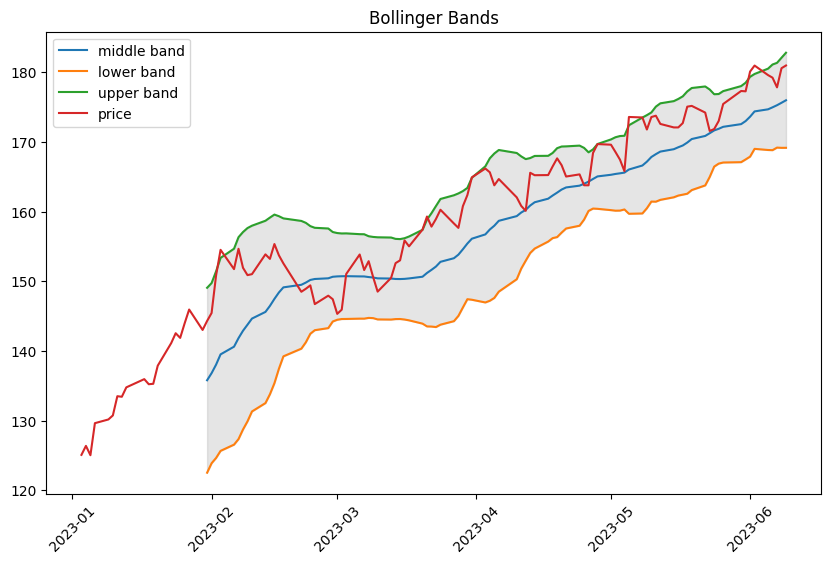

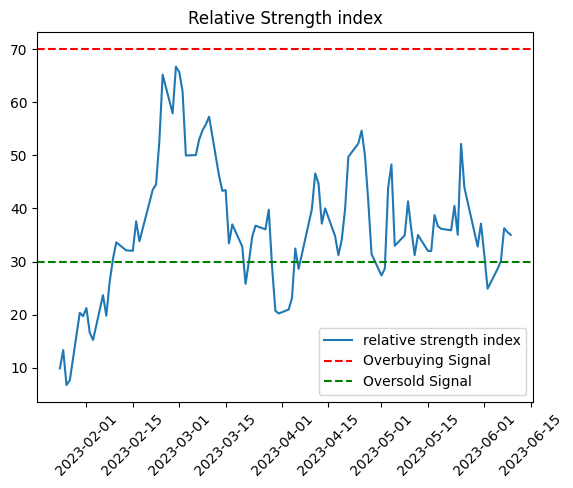

In [ ]:
dataframe = bollinger_bands(data.Close, n=20, k=2)
dataframe["Close"] = data.Close
dataframe["rsi"] = rsi(df.Close, 14)


In [ ]:
dataframe["signal"] = dataframe.apply(lambda x: buy_sell_signal(x.Close, 
                                      x.lower_band_bb,
                                      x.upper_band_bb,
                                      x.rsi), axis=1)

In [ ]:
if dataframe["signal"][-1] == 1:
  api.submit_order(
      symbol=ticker,
      qty=qty,
      sid="buy",
      type="market",
      time_inforce="gtc"
  )

elif dataframe["signal"][-1]  == 2:
  api.submit_order(
      symbol=ticker,
      qty=qty,
      side="sell",
      type="market",
      time_in_force="gtc"
  )

else:
  print("No signal, holding position")


orders = api.list_orders(status='all')
for order in orders:
    print(f"Order status: {order.status}, Symbol: {order.symbol}, Side: {order.side}, Quantity: {order.qty}")

No signal, holding position
